In [43]:
import tensorflow as tf
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import ConfusionMatrixDisplay,f1_score
from sklearn.metrics import confusion_matrix

In [2]:
image_directory = 'imgs/Resized_Skin_Lesion_Dataset/Train_images/Trainx/'
mask_directory = 'imgs/Resized_Skin_Lesion_Dataset/Train_masks/Trainy/'

In [3]:
SIZE = 256
image_dataset = [] 
mask_dataset = [] 

In [4]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'bmp'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [5]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'bmp'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [6]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = (np.expand_dims((np.array(mask_dataset)),3)>=125).astype('int16')

In [7]:
np.unique(mask_dataset)

array([0, 1], dtype=int16)

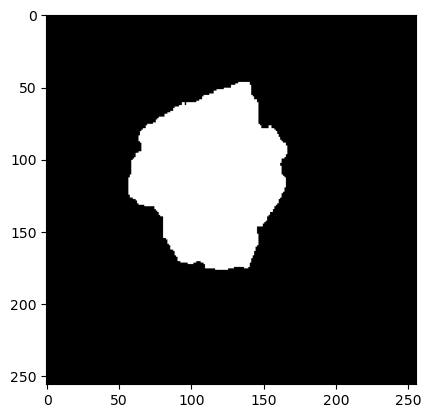

In [8]:
plt.imshow(mask_dataset[55], cmap = 'gray')

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

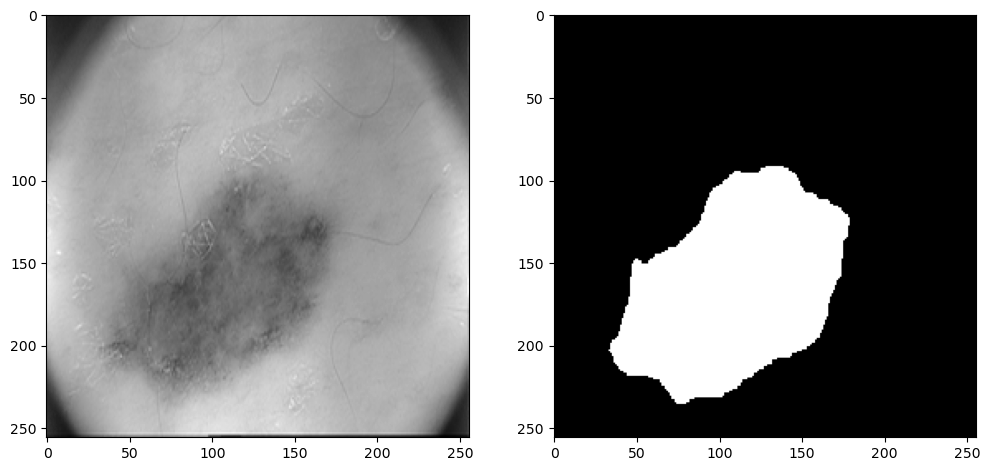

In [10]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model
 

In [12]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()


#If starting with pre-trained weights. 
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')

history = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('unetph2.hdf5')

2023-09-21 13:26:24.914163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 13:26:25.600732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14625 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

2023-09-21 13:26:28.305309: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


45/45 [==============================] - 5s 28ms/step - loss: 0.6693 - accuracy: 0.6309 - val_loss: 0.5903 - val_accuracy: 0.7432
Epoch 2/100
45/45 [==============================] - 1s 21ms/step - loss: 0.6250 - accuracy: 0.6700 - val_loss: 0.5533 - val_accuracy: 0.7432
Epoch 3/100
45/45 [==============================] - 1s 21ms/step - loss: 0.6204 - accuracy: 0.6700 - val_loss: 0.5504 - val_accuracy: 0.7432
Epoch 4/100
45/45 [==============================] - 1s 21ms/step - loss: 0.6157 - accuracy: 0.6700 - val_loss: 0.5409 - val_accuracy: 0.7432
Epoch 5/100
45/45 [==============================] - 1s 22ms/step - loss: 0.6049 - accuracy: 0.6815 - val_loss: 0.5209 - val_accuracy: 0.7432
Epoch 6/100
45/45 [==============================] - 1s 21ms/step - loss: 0.6092 - accuracy: 0.6696 - val_loss: 0.5331 - val_accuracy: 0.7432
Epoch 7/100
45/45 [==============================] - 1s 21ms/step - loss: 0.5930 - accuracy: 0.6715 - val_loss: 0.5010 - val_accuracy: 0.7760
Epoch 8/100
45/45 

45/45 [==============================] - 1s 21ms/step - loss: 0.0866 - accuracy: 0.9645 - val_loss: 0.2012 - val_accuracy: 0.9486
Epoch 59/100
45/45 [==============================] - 1s 20ms/step - loss: 0.0794 - accuracy: 0.9675 - val_loss: 0.1928 - val_accuracy: 0.9429
Epoch 60/100
45/45 [==============================] - 1s 21ms/step - loss: 0.0788 - accuracy: 0.9671 - val_loss: 0.2019 - val_accuracy: 0.9453
Epoch 61/100
45/45 [==============================] - 1s 22ms/step - loss: 0.0774 - accuracy: 0.9678 - val_loss: 0.2023 - val_accuracy: 0.9466
Epoch 62/100
45/45 [==============================] - 1s 21ms/step - loss: 0.0931 - accuracy: 0.9629 - val_loss: 0.2296 - val_accuracy: 0.9297
Epoch 63/100
45/45 [==============================] - 1s 21ms/step - loss: 0.0891 - accuracy: 0.9638 - val_loss: 0.1859 - val_accuracy: 0.9467
Epoch 64/100
45/45 [==============================] - 1s 21ms/step - loss: 0.0854 - accuracy: 0.9649 - val_loss: 0.2337 - val_accuracy: 0.9347
Epoch 65/100

In [13]:
# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 1s 907ms/step - loss: 0.1781 - accuracy: 0.9474
Accuracy =  94.73968744277954 %


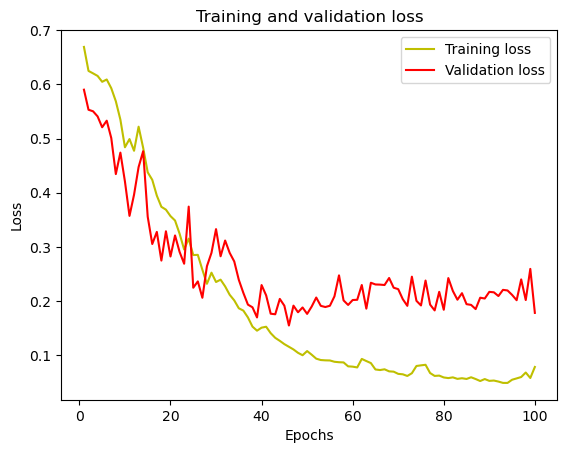

In [14]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

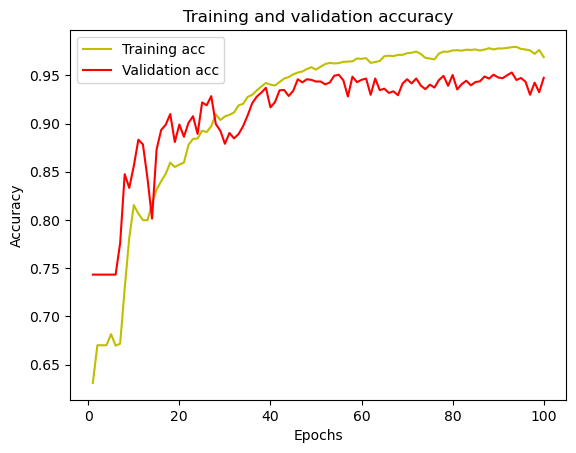

In [15]:
acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)

1/1 [==============================] - 0s 250ms/step
IoU score is:  0.8058032570794441


In [17]:
def enhance(img):
    sub = (model.predict(img.reshape(1,256,256,1))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

### In the above function, changed the threshold value to 0.2 from 0.5. This shows how much confidence our model shows in the prediction

1/1 [==============================] - 0s 26ms/step


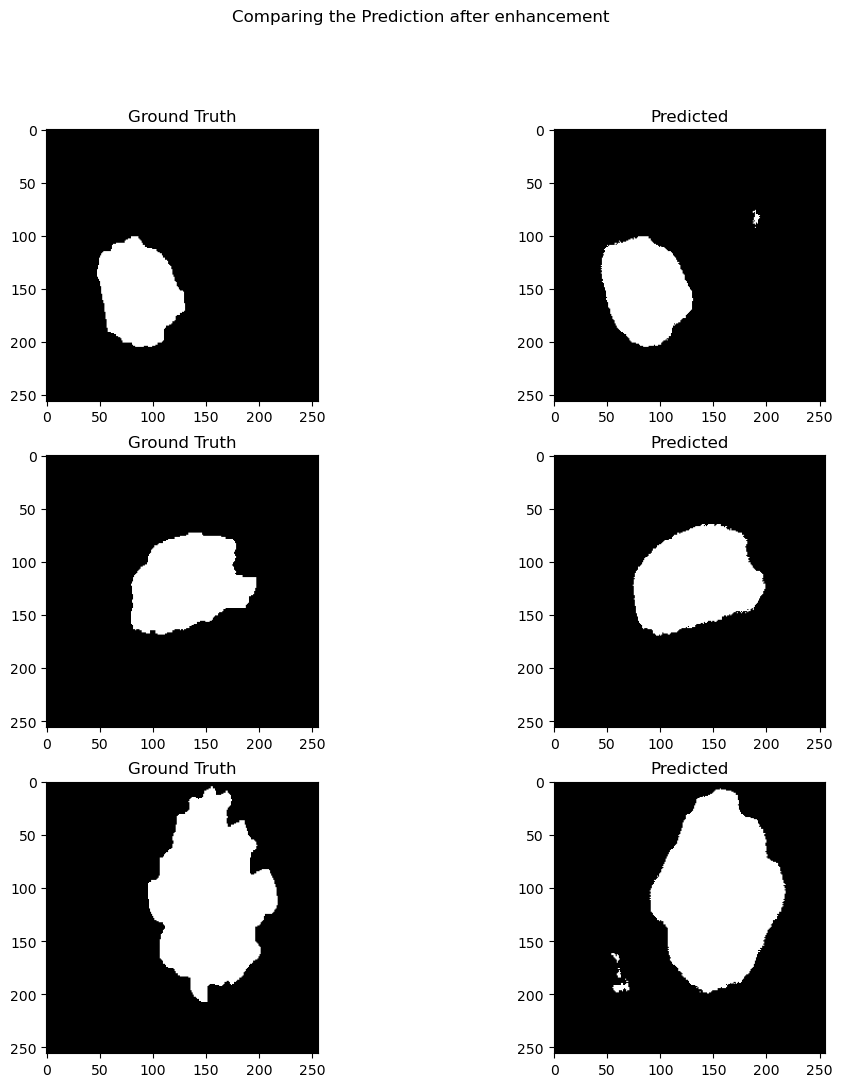

In [18]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[9],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(X_test[9]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[13],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(X_test[13]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[17],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(X_test[17]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

In [19]:
# All training images
sum_iou=0
for test_img_number in range(X_train.shape[0]):
    test_img = X_train[test_img_number]
    ground_truth=y_train[test_img_number]
    prediction = enhance(test_img).reshape(256,256)
    IOU_keras = MeanIoU(num_classes=2)  
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
m_iou_simple = sum_iou/X_train.shape[0]
print("Mean IoU: ", m_iou_simple)

1/1 [==============================] - 0s 25ms/step
IoU for the current prediction = 0.90559936
1/1 [==============================] - 0s 25ms/step
IoU for the current prediction = 0.8678572
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.91167885
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.84087825
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.8913611
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.8890141
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.91998553
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.9367038
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.8957275
1/1 [==============================] - 0s 26ms/step
IoU for the current prediction = 0.87052023
1/1 [==============================] - 0s 26m

1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.76396525
1/1 [==============================] - 0s 25ms/step
IoU for the current prediction = 0.94473153
1/1 [==============================] - 0s 25ms/step
IoU for the current prediction = 0.8969851
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.87748945
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.9183297
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.9489796
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.9220677
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.90612185
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.92151237
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.8837292
1/1 [==============================] - 0s 24m

1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.9401364
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.96094644
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.95325124
1/1 [==============================] - 0s 25ms/step
IoU for the current prediction = 0.8918381
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.86515224
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.88515997
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.94802165
1/1 [==============================] - 0s 24ms/step
IoU for the current prediction = 0.917165
Mean IoU:  89.49663187066714


In [20]:
# For all train images
pred_train_array = []
for i in X_train:
    pred_train_array.append(enhance(i).reshape(256,256))

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


In [21]:
print("Prediction array size: ", len(pred_train_array))

Prediction array size:  180


In [22]:
flat_truth_arr = y_train.flatten()

In [23]:
np.unique(flat_truth_arr)

array([0, 1], dtype=int16)

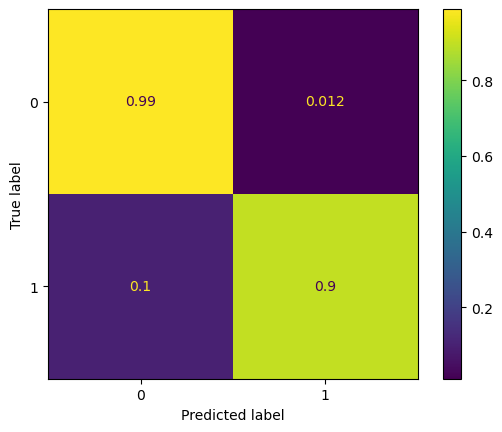

In [24]:
flat_preds_arr = np.array(pred_train_array).flatten()
cm = confusion_matrix(flat_truth_arr, flat_preds_arr, labels=list(range(2)))
ConfusionMatrixDisplay.from_predictions(flat_truth_arr, flat_preds_arr, normalize='true')

In [25]:
# Calculating the True Positive Rate, False Positive Rate
def tpr_fpr_tnr_fnr(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr, fnr = 1-tpr, 1-fpr
    return tpr, fpr, tnr, fnr

In [26]:
tpr, fpr, tnr, fnr = tpr_fpr_tnr_fnr(cm)
print("True Positive Rate(TPR): ",tpr)
print("False Positive Rate(FPR): ",fpr)
print("True Negative Rate(TNR): ", tnr)
print("False Negative Rate(FNR): ", fnr)

True Positive Rate(TPR):  0.8994887009459225
False Positive Rate(FPR):  0.011650853961969796
True Negative Rate(TNR):  0.10051129905407752
False Negative Rate(FNR):  0.9883491460380303


In [27]:
print("F1 score of the predictions: ",f1_score(flat_truth_arr, flat_preds_arr, average='macro'))

F1 score of the predictions:  0.9527124112553286


In [30]:
# Mean IoU for all testing images
sum_iou=0
for test_img_number in range(X_test.shape[0]):
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]

    prediction = enhance(test_img).reshape(256,256)

    IOU_keras = MeanIoU(num_classes=2)
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
m_iou_simple = sum_iou/X_test.shape[0]
print("Mean IoU: ", m_iou_simple)

1/1 [==============================] - 0s 33ms/step
IoU for the current prediction = 0.8461973
1/1 [==============================] - 0s 29ms/step
IoU for the current prediction = 0.9467142
1/1 [==============================] - 0s 31ms/step
IoU for the current prediction = 0.94904673
1/1 [==============================] - 0s 29ms/step
IoU for the current prediction = 0.3082499
1/1 [==============================] - 0s 28ms/step
IoU for the current prediction = 0.9427432
1/1 [==============================] - 0s 28ms/step
IoU for the current prediction = 0.9129833
1/1 [==============================] - 0s 28ms/step
IoU for the current prediction = 0.9014326
1/1 [==============================] - 0s 28ms/step
IoU for the current prediction = 0.79612625
1/1 [==============================] - 0s 28ms/step
IoU for the current prediction = 0.88989687
1/1 [==============================] - 0s 27ms/step
IoU for the current prediction = 0.9421593
1/1 [==============================] - 0s 28ms/

In [34]:
# For all test images
pred_test_array = []
for i in X_test:
    pred_test_array.append(enhance(i).reshape(256,256))

1/1 [==============================] - 0s 28ms/step


In [35]:
print("Prediction array size: ", len(pred_test_array))

Prediction array size:  20


In [37]:
flat_truth_arr = y_test.flatten()

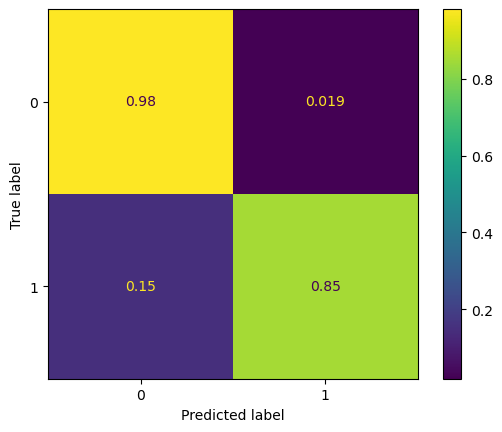

In [38]:
flat_preds_arr = np.array(pred_test_array).flatten()
cm = confusion_matrix(flat_truth_arr, flat_preds_arr, labels=list(range(2)))
ConfusionMatrixDisplay.from_predictions(flat_truth_arr, flat_preds_arr, normalize='true')

In [39]:
# Calculating the True Positive Rate, False Positive Rate
def tpr_fpr_tnr_fnr(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr, fnr = 1-tpr, 1-fpr
    return tpr, fpr, tnr, fnr

In [40]:
tpr, fpr, tnr, fnr = tpr_fpr_tnr_fnr(cm)
print("True Positive Rate(TPR): ",tpr)
print("False Positive Rate(FPR): ",fpr)
print("True Negative Rate(TNR): ", tnr)
print("False Negative Rate(FNR): ", fnr)

True Positive Rate(TPR):  0.8501242080990812
False Positive Rate(FPR):  0.019000439340250547
True Negative Rate(TNR):  0.14987579190091882
False Negative Rate(FNR):  0.9809995606597495


In [49]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
